In [1]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
from scipy.linalg import expm, logm
sys.path.append('../') # Add parent directory to the system path

In [2]:
# This import requires previous directory to be appended to sys.path
from direct_decomposition import direct_decomposition, random_unitary

In [3]:
def a(n):
    """
    Annihilation operator truncated at n photons, 
    """
    d = n + 1 # The unpadded creation operator truncated at n photons has dimension dxd
    matrix = np.zeros((d, d))
    for i in range(1, d):
        matrix[i-1, i] = np.sqrt(i)
    # matrix = pad_matrix(matrix) # Pad with zeros
    return matrix

def ad(n):
    """
    Creation operator truncated at n photons
    """
    return np.transpose(a(n))

In [4]:
def op_basis_element(M, N, i, j):
    """
    Get the (i,j)th basis element of an M mode interferometer supporting up to N photons
    Where i is the index of the creation operator and j is the index of the annihilation operator

    Example 1:
    (M = 3, N = 2, i = 1, j = 1)

    $$ I_{(N=2)} \otimes a^\dagger_{(N=2)} a_{(N=2)} \otimes I_{(N=2)} $$

    Example 2:
    (M = 4, N = 4, i = 0, j = 3)

    $$ a^\dagger_{(N=4)} \otimes I_{(N=4)} \otimes I_{(N=4)} \otimes a_{(N=4)} $$
    """

    def get_kronecker_term(idx):
        """
        Find the kth term in the kronecker product of the basis element where k = idx.

        Example:
            Suppose the basis operator has the form
            $$a_{(N)}^\dagger \otimes a_{(N)} $$

            get_kronecker_term(1) would $a_{(N)}^\dagger$.
        """
        if idx == i and idx == j:
            return ad(N) @ a(N)
        elif idx == i:
            return ad(N)
        elif idx == j:
            return a(N)
        else:
            return np.eye(N+1, N+1) 
            # Plus one since this happens implicitly in the a() and ad() functions

    assert(i < M and j < M), "Index or indices out of range"
    basis_element = get_kronecker_term(0)
    for k in range(1, M):
        kron_term = get_kronecker_term(k)
        basis_element = np.kron(basis_element, kron_term)
    return basis_element


Test case: $M = 2$, $N = 2$, $i = 0$, $j = 1$
$$
\begin{pmatrix}
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & \sqrt{2} & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

In [5]:
# Comparing test case to mathematica output:
test_element = op_basis_element(2, 2, 0, 1)
print(np.shape(test_element))
print(np.array_str(test_element))
# Output is matching -- test passed

(9, 9)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


In [6]:
def expanded_unitary(U, N):
    """
    This function takes a unitary U corresponding to the action of an M mode interferometer on the 
    creation operators and returns a unitary in the second quantization picture that can support up
    to N photons per mode.
    """
    M = np.shape(U)[0]
    # Get Hamiltonian from unitary:
    H = -1j * logm(U)
    expanded_H = 0
    # Sum basis elements multiplied by the corresponding Hamiltonian terms
    for i in range(M):
        for j in range(M):
            expanded_H += H[i][j] * op_basis_element(M, N, i, j)
    return expm(1j * expanded_H)

In [7]:
# Test expanded_unitary
r2 = 1/np.sqrt(2)
test_U = np.matrix([[r2, r2, 0],[r2,-r2,0],[0,0,1]])
test_U_expd = expanded_unitary(test_U, 2)
print(sum(np.diag(test_U_expd)))
# Expected value of this checksum I'm printing:
# 9. + 4.7475 i (Verified by Mathematica)


(9.000000000000004+4.747500951788335j)


In [8]:
# Make a random unitary R to simulate
R = random_unitary(3)
U_expd = expanded_unitary(R, 3)
print(R)
print(np.shape(U_expd))

[[ 0.17475129+0.15747238j  0.60300041-0.73473431j -0.18958056+0.07266119j]
 [-0.14792722-0.6784198j   0.30490579-0.04605917j  0.56902903+0.3146126j ]
 [-0.26108468+0.62798355j -0.02679824+0.02736547j  0.33848223+0.64917965j]]
(64, 64)


In [9]:
# Initialize statevector

def make_initial_state(qubit_bitstring):
    """
    Given some bitstring representing an initial qubit state,
    this function finds the corresponding statevector.

    Example:
        qubit_bitstring = [0,1]
        initial state = $|01\rangle$
        return np.matrix[[0,1,0,0]]
    """

    ket_0 = np.matrix([1,0])
    ket_1 = np.matrix([0,1])

    # Tidy me
    if qubit_bitstring[0] == 0:
        initial_state = ket_0
    elif qubit_bitstring[0] == 1:
        initial_state = ket_1

    for qubit in qubit_bitstring[1::]:
        if qubit == 0:
            initial_state = np.kron(initial_state, ket_0)
        if qubit == 1:
            initial_state = np.kron(initial_state, ket_1)
    
    return np.transpose(initial_state)

qubit_bitstring = [0,1,0,1,0,0]
initial_state = make_initial_state(qubit_bitstring)
final_state = U_expd @ initial_state
expectation_values = np.square(np.abs(final_state)) # Expectation values for observables

In [19]:
def reverse_blocks(string, m):
    """
    This function splits a string up into blocks of length m, reverses the 
    order of the blocks and returns the resulting string
    """
    blocks = [string[i:i+m] for i in range(0, len(string), m)]
    reversed_blocks = blocks[::-1]
    reversed_string = ''.join(reversed_blocks)
    return reversed_string


def format_bitstring(observable, num_qubits = 6, qubits_per_mode = 2, little_endian = True):
    """
    This function takes an observable (integer) and converts it into a bitstring in the qiskit
    convention.

    First, the observable is represented in binary, and padded with zeros on the left hand side
    up to the number of qubits.

    Then, the bitstring is split up into m blocks, where m = qubits_per_mode. The order of the blocks
    is reversed and the resulting string is returned.
    """
    bitstring = bin(observable)[2:]
    bitstring = '0' * (num_qubits - len(bitstring)) + bitstring 
    # Iterate over the bit string in m-step increments and flip substrings
    final_bitstring = reverse_blocks(bitstring, qubits_per_mode)
    return final_bitstring


def format_expectations(expectation_values):
    """
    Convert the expectations into a dictionary compatible with qiskit formatting
    """
    exp_dict = dict()
    for idx, val in enumerate(expectation_values[:]):
        if val != 0.0:
            bitstring = format_bitstring(idx)
            exp_dict[bitstring] = float(val)
    return exp_dict


def pprint_expectations(expectation_values):
    """
    Pretty print the expectation values generated in the previous cell
    """
    for idx, val in enumerate(expectation_values[:]):
        if val != 0.0:
            print(f"idx: {idx},  val: {float(val)}")
            print(format_bitstring(idx))

pprint_expectations(expectation_values)
exp_dict = format_expectations(expectation_values)
    

idx: 2,  val: 0.0013570718761097811
100000
idx: 5,  val: 0.04815690441218597
010100
idx: 8,  val: 0.09169162564583623
001000
idx: 17,  val: 0.4131245136453289
010001
idx: 20,  val: 0.3456847196121041
000101
idx: 32,  val: 0.09998516480843418
000010
{'100000': 0.0013570718761097811, '010100': 0.04815690441218597, '001000': 0.09169162564583623, '010001': 0.4131245136453289, '000101': 0.3456847196121041, '000010': 0.09998516480843418}


In [15]:


reverse_blocks("011010", 2)

'101001'

In [22]:
def run_circuit_simulation(num_shots):
    circuit = QuantumCircuit(6)
    circuit.initialize("000101")
    interferom = direct_decomposition(R, 2)
    circuit.compose(interferom, qubits=list(range(6)), inplace=True)
    circuit.measure_all()

    simulator = AerSimulator()
    circuit = transpile(circuit, simulator)
    result = simulator.run(circuit, shots=num_shots).result()
    counts = result.get_counts(circuit)

    # Convert counts to probabilities
    for key in counts.keys():
        counts[key] = counts[key] / num_shots
    return counts


In [31]:
shots_1e3 = run_circuit_simulation(1e3)

In [29]:
shots_1e4 = run_circuit_simulation(1e4)

In [ ]:
shots_1e5 = run_circuit_simulation(1e5)

In [ ]:
shots_1e6 = run_circuit_simulation(1e6)

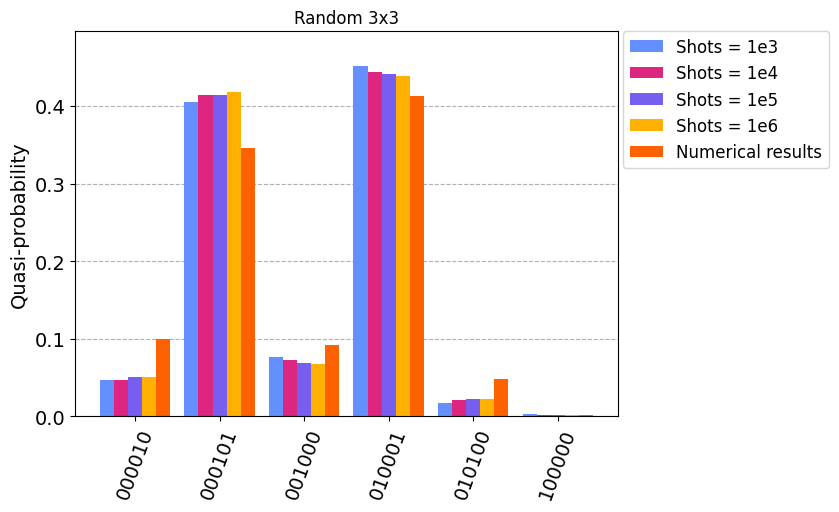

In [32]:
legend = ['Shots = 1e3', 'Shots = 1e4', 'Shots = 1e5', 'Numerical results']
plot_histogram([shots_1e3, shots_1e4, shots_1e5, shots_1e6, exp_dict], legend=legend, title='Random 3x3', bar_labels=False)